Alex Verbs, Kristina Schaufele, Reese Wolfe 

In [5]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import numpy as np
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.models import load_model
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


# Loading the Data:

In [6]:
imageDir = "data"

# Subdirectories for datasets
datasets = ['Testing', 'Training']

for dataset in datasets:
    dataset_path = os.path.join(imageDir, dataset)
    if not os.path.isdir(dataset_path):
        continue  # Skip if the dataset directory does not exist
    print(f"\nDataset: {dataset}")
    print(f"")
    
    # Get all tumor type directories within the dataset directory
    tumor_types = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    for tumor_type in tumor_types:
        tumor_path = os.path.join(dataset_path, tumor_type)
        
        # List all files (images) in the tumor type directory
        images = [f for f in os.listdir(tumor_path) if os.path.isfile(os.path.join(tumor_path, f))]
        num_images = len(images)
        
        print(f"  Tumor Type: {tumor_type}, Number of images: {num_images}")
        print(f"")




Dataset: Testing

  Tumor Type: pituitary, Number of images: 300

  Tumor Type: notumor, Number of images: 405

  Tumor Type: glioma, Number of images: 300

  Tumor Type: meningioma, Number of images: 306


Dataset: Training

  Tumor Type: pituitary, Number of images: 1457

  Tumor Type: notumor, Number of images: 1595

  Tumor Type: glioma, Number of images: 1321

  Tumor Type: meningioma, Number of images: 1339




Dataset: Testing
  Tumor Type: pituitary, Number of images: 300
  Tumor Type: notumor, Number of images: 405
  Tumor Type: glioma, Number of images: 300
  Tumor Type: meningioma, Number of images: 306

Dataset: Training
  Tumor Type: pituitary, Number of images: 1457
  Tumor Type: notumor, Number of images: 1595
  Tumor Type: glioma, Number of images: 1321
  Tumor Type: meningioma, Number of images: 1339


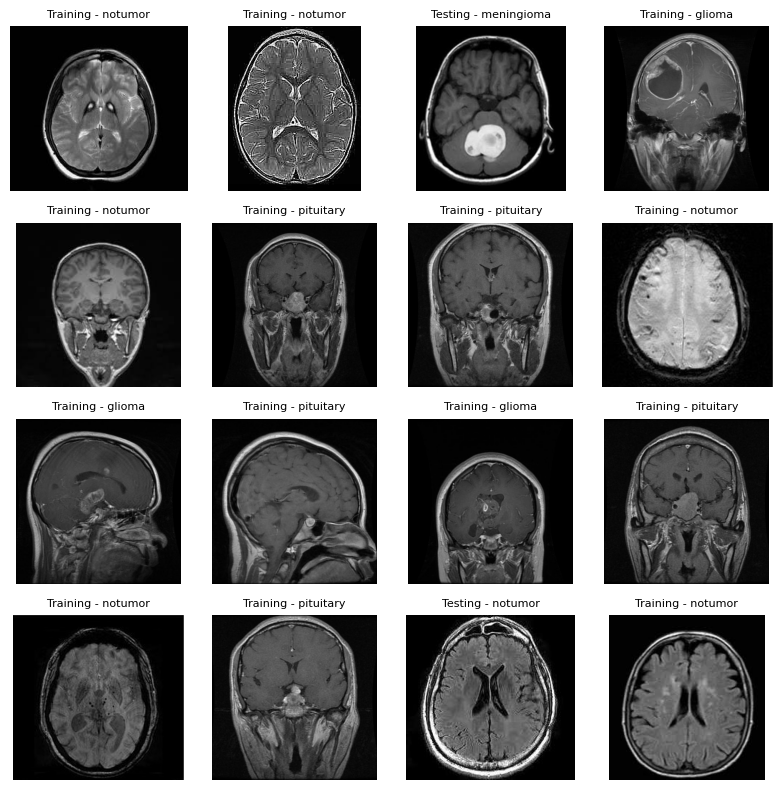

In [7]:
import random

# Collect sample images and their labels
sample_images = []
labels = []

for dataset in datasets:
    dataset_path = os.path.join(imageDir, dataset)
    if not os.path.isdir(dataset_path):
        print(f"Dataset directory not found: {dataset_path}")
        continue  # Skip if the dataset directory does not exist
    print(f"\nDataset: {dataset}")
    
    # Get all tumor type directories within the dataset directory
    tumor_types = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    for tumor_type in tumor_types:
        tumor_path = os.path.join(dataset_path, tumor_type)
        
        # List all files (images) in the tumor type directory
        images = [f for f in os.listdir(tumor_path) if os.path.isfile(os.path.join(tumor_path, f))]
        num_images = len(images)
        
        print(f"  Tumor Type: {tumor_type}, Number of images: {num_images}")
        
        if num_images == 0:
            print(f"  No images found in {tumor_path}")
            continue  # Skip to the next tumor type if no images are found
        
        # Add all images from each tumor type to the sample lists
        for image_file in images:
            image_path = os.path.join(tumor_path, image_file)
            sample_images.append(image_path)
            labels.append(f"{dataset} - {tumor_type}")

# Randomize the collected images
combined_data = list(zip(sample_images, labels))
random.shuffle(combined_data)

# Limit to 16 random images
sample_images, labels = zip(*combined_data[:16])

# Display images in a 4x4 grid
fig, axes = plt.subplots(4, 4, figsize=(8, 8))  # Adjust figsize to make images smaller or larger
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for idx, ax in enumerate(axes):
    if idx < len(sample_images):
        image_path = sample_images[idx]
        img = mpimg.imread(image_path)
        ax.imshow(img, cmap='gray')
        ax.set_title(labels[idx], fontsize=8)
        ax.axis('off')
    else:
        ax.axis('off')  # Hide any unused subplots

plt.tight_layout()
plt.show()

In [8]:
# Parameters
img_height = 180  # Set your desired image height
img_width = 180   # Set your desired image width
batch_size = 32   # Set your desired batch size

# Directory paths for training and testing
train_dir = "data/Training"
test_dir = "data/Testing"

# Load the training dataset
train_ds = keras.utils.image_dataset_from_directory(
    train_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Load the testing dataset
test_ds = keras.utils.image_dataset_from_directory(
    test_dir,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


# Baseline Accuracy

In [17]:

class_counts = {'notumor': 0, 'glioma': 0, 'meningioma': 0, 'pituitary': 0}
dataset_path = os.path.join(imageDir, 'Training')

print(f"\nDataset: {'Training'}")
print(f"")

# Get all tumor type directories within the dataset directory
tumor_types = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
for tumor_type in tumor_types:
    tumor_path = os.path.join(dataset_path, tumor_type)
    
    # List all files (images) in the tumor type directory
    images = [f for f in os.listdir(tumor_path) if os.path.isfile(os.path.join(tumor_path, f))]
    num_images = len(images)
    
        # Adjust class names as per your folder names
    if "notumor" in tumor_type:
        class_counts['notumor'] += num_images
    elif "glioma" in tumor_type:
        class_counts['glioma'] += num_images
    elif "meningioma" in tumor_type:
        class_counts['meningioma'] += num_images
    elif "pituitary" in tumor_type:
        class_counts['pituitary'] += num_images

    # Print the class counts before calculating baseline accuracy
print("Class Counts:", class_counts)

# Calculate baseline accuracy for subtypes
total_images = class_counts['notumor'] + class_counts['glioma'] + class_counts['meningioma'] + class_counts['pituitary']
majority_class_count = max(class_counts.values())
baseline_accuracy = majority_class_count / total_images

print(f"Baseline Accuracy for 4 Categories: {baseline_accuracy:.2%}")

# Calculate baseline accuracy for subtypes
total_tumors = class_counts['glioma'] + class_counts['meningioma'] + class_counts['pituitary']
no_tumors = class_counts['notumor']
binary_baseline_accuracy = total_tumors/ total_images
print(f"Baseline Accuracy for 2 Categories: {binary_baseline_accuracy:.2%}")



Dataset: Training

Class Counts: {'notumor': 1595, 'glioma': 1321, 'meningioma': 1339, 'pituitary': 1457}
Baseline Accuracy for 4 Categories: 27.92%
Baseline Accuracy for 2 Categories: 72.08%


# Transfer learning with ResNet